# Enrichment Analysis

## Get basic structure of data

One problem with using the notebook is that it is a little harder to look at datasets, you need to explicitly print things out. This section is where I keep those print out just for reference.

### CEGS Data Sets

In [1]:
libname CEGS '/home/jfear/mclab/cegs_ase_paper/sas_data/';

proc datasets library=cegs nodetails;

In [2]:
*proc print data=CEGS.r2_ct_models (obs=10); run;

In [3]:
*proc print data=CEGS.CIS_EST_V13 (obs=10); run;

### Useful Dmel Data Sets

In [4]:
libname DMEL '/home/jfear/mclab/useful_dmel_data/flybase551/sasdata';

proc datasets library=DMEL nodetails;

In [5]:
proc print data=DMEL.FB551_SI_FUSIONS_UNIQUE_FLAGGED(obs=10); run;

Obs,fusion_id,Genes_per_fusion,Exons_per_fusion,FBgns_per_fusion,FBpps_per_fusion,FBtrs_per_fusion,chrom,start,end,symbol_cat,Exon_Gene_ID_cat,exon_ID_cat,Exon_Name_cat,FBtrs_per_exon_cat,FBgn_cat,FBpp_cat,FBtr_cat,max_fbtr_per_gene_symbol,min_fbtr_per_gene_symbol_cat,max_fbtr_per_gene_symbol_cat,Constitutive,Common,Alternative,most_three_prime_exon
1,F10001_SI,2,2,2,2,2,2L,19042380,19043883,Catsup|Ttc19,FBgn0002022|FBgn0032744,FBgn0002022:2|FBgn0032744:1,Catsup:2|Ttc19:1,1|1,FBgn0002022|FBgn0032744,FBpp0080687|FBpp0080720,FBtr0081143|FBtr0081178,.,2,2,0,1,0,1
2,F10005_SI,1,3,1,3,3,2L,19045355,19047047,Acn,FBgn0263198,FBgn0263198:1|FBgn0263198:2|FBgn0263198:3,Acn:1|Acn:2|Acn:3,1|2|1,FBgn0263198,FBpp0080688|FBpp0080689|FBpp0307803,FBtr0081144|FBtr0081145|FBtr0336842,3,3,3,0,1,0,0
3,F10009_SI,1,3,1,3,3,2L,19047914,19048817,Acn,FBgn0263198,FBgn0263198:7|FBgn0263198:8|FBgn0263198:9,Acn:7|Acn:8|Acn:9,1|1|1,FBgn0263198,FBpp0080688|FBpp0080689|FBpp0307803,FBtr0081144|FBtr0081145|FBtr0336842,3,3,3,0,1,0,1
4,F10012_SI,2,2,2,2,2,2L,19049422,19051034,CG10470|l(2)37Bb,FBgn0032746|FBgn0002021,FBgn0002021:1|FBgn0032746:3,l(2)37Bb:1|CG10470:3,1|1,FBgn0002021|FBgn0032746,FBpp0080690|FBpp0080719,FBtr0081146|FBtr0081177,.,2,2,0,1,0,1
5,F10014_SI,1,2,1,2,2,2L,19051790,19052217,Rpn3,FBgn0261396,FBgn0261396:1|FBgn0261396:2,Rpn3:1|Rpn3:2,1|1,FBgn0261396,FBpp0291495|FBpp0307804,FBtr0302289|FBtr0336843,2,2,2,0,1,0,0
6,F10018_SI,1,2,1,2,2,2L,19056252,19058821,CG10492,FBgn0032748,FBgn0032748:3|FBgn0032748:4,CG10492:3|CG10492:4,1|1,FBgn0032748,FBpp0080692|FBpp0111956,FBtr0081148|FBtr0113043,2,2,2,0,1,0,1
7,F10019_SI,1,2,1,2,2,2L,19059129,19059850,Phlpp,FBgn0032749,FBgn0032749:1|FBgn0032749:2,Phlpp:1|Phlpp:2,1|1,FBgn0032749,FBpp0080693|FBpp0307805,FBtr0081149|FBtr0336844,2,2,2,0,1,0,0
8,F10032_SI,2,6,2,5,5,2L,19068203,19069850,CG10702|CG17343,FBgn0032752|FBgn0032751,FBgn0032751:2|FBgn0032752:10|FBgn0032752:6|FBgn0032752:7|FBgn0032752:8|FBgn0032752:9,CG17343:2|CG10702:10|CG10702:6|CG10702:7|CG10702:8|CG10702:9,1|2|2|1|1|1,FBgn0032751|FBgn0032752,FBpp0080695|FBpp0080716|FBpp0080717|FBpp0080718|FBpp0292333,FBtr0081151|FBtr0081174|FBtr0081175|FBtr0081176|FBtr0303241,.,5,5,0,1,0,1
9,F10049_SI,2,2,2,2,2,2L,19102044,19102104,CG17344|CG43731,FBgn0032755|FBgn0263982,FBgn0032755:1|FBgn0263982:1,CG17344:1|CG43731:1,1|1,FBgn0032755|FBgn0263982,FBpp0080696|FBpp0303052,FBtr0081152|FBtr0330018,.,2,2,0,1,0,0
10,F10050_SI,2,2,2,2,2,2L,19102168,19102909,CG17344|CG43731,FBgn0032755|FBgn0263982,FBgn0032755:2|FBgn0263982:2,CG17344:2|CG43731:2,1|1,FBgn0032755|FBgn0263982,FBpp0080696|FBpp0303052,FBtr0081152|FBtr0330018,.,2,2,0,1,0,1


## Looking at models

Trying to figure out what the models Lauren made look like. I am going to move forward with the interaction model.

CEGS.ai_reg_parms_ful

In [6]:
proc print data=CEGS.ai_reg_fit_full2 (obs=10); run;

Obs,fusion_id,mating_status,R2_full
1,F10005_SI,M,0.9841
2,F10005_SI,V,0.9636
3,F10060_SI,M,0.8104
4,F10060_SI,V,0.8600
5,F10136_SI,M,0.9046
6,F10136_SI,V,0.9369
7,F10268_SI,M,0.9757
8,F10268_SI,V,0.9740
9,F10317_SI,M,0.8816
10,F10317_SI,V,0.9078


In [7]:
proc print data=CEGS.ai_reg_parms_full (obs=10); run;

Obs,fusion_id,mating_status,Model,Dependent,Variable,DF,Estimate,StdErr,tValue,Probt,sign_parm
1,F10005_SI,M,MODEL1,q5_mean_theta,Intercept,1,0.50743,0.00215,236.30,<.0001,+
2,F10005_SI,M,MODEL1,q5_mean_theta,c_i,1,-1.86431,0.05181,-35.98,<.0001,-
3,F10005_SI,M,MODEL1,q5_mean_theta,T_i_1a,1,-0.00173,0.02146,-0.08,0.9364,-
4,F10005_SI,M,MODEL1,q5_mean_theta,int,1,2.13998,0.35341,6.06,<.0001,+
5,F10005_SI,V,MODEL1,q5_mean_theta,Intercept,1,0.50404,0.00245,205.98,<.0001,+
6,F10005_SI,V,MODEL1,q5_mean_theta,c_i,1,-1.88200,0.09409,-20.00,<.0001,-
7,F10005_SI,V,MODEL1,q5_mean_theta,T_i_1a,1,0.07370,0.02406,3.06,0.0050,+
8,F10005_SI,V,MODEL1,q5_mean_theta,int,1,4.42754,0.58473,7.57,<.0001,+
9,F10060_SI,M,MODEL1,q5_mean_theta,Intercept,1,0.49708,0.01189,41.81,<.0001,+
10,F10060_SI,M,MODEL1,q5_mean_theta,c_i,1,-1.79861,0.19850,-9.06,<.0001,-


In [8]:
proc print data=CEGS.ai_reg_fit_full (obs=10); run;

Obs,fusion_id,mating_status,Model,Dependent,Label1,cValue1,nValue1,Label2,cValue2,nValue2
1,F10005_SI,M,MODEL1,q5_mean_theta,Dependent Mean,0.50210,0.502100,Adj R-Sq,0.9841,0.984129
2,F10005_SI,V,MODEL1,q5_mean_theta,Dependent Mean,0.50273,0.502733,Adj R-Sq,0.9636,0.963552
3,F10060_SI,M,MODEL1,q5_mean_theta,Dependent Mean,0.49234,0.492345,Adj R-Sq,0.8104,0.810425
4,F10060_SI,V,MODEL1,q5_mean_theta,Dependent Mean,0.47579,0.475793,Adj R-Sq,0.8600,0.859964
5,F10136_SI,M,MODEL1,q5_mean_theta,Dependent Mean,0.53008,0.530083,Adj R-Sq,0.9046,0.904646
6,F10136_SI,V,MODEL1,q5_mean_theta,Dependent Mean,0.53413,0.534125,Adj R-Sq,0.9369,0.936881
7,F10268_SI,M,MODEL1,q5_mean_theta,Dependent Mean,0.48586,0.485857,Adj R-Sq,0.9757,0.975698
8,F10268_SI,V,MODEL1,q5_mean_theta,Dependent Mean,0.49090,0.490905,Adj R-Sq,0.9740,0.973953
9,F10317_SI,M,MODEL1,q5_mean_theta,Dependent Mean,0.09414,0.094139,Adj R-Sq,0.8816,0.881597
10,F10317_SI,V,MODEL1,q5_mean_theta,Dependent Mean,0.09178,0.091778,Adj R-Sq,0.9078,0.907815



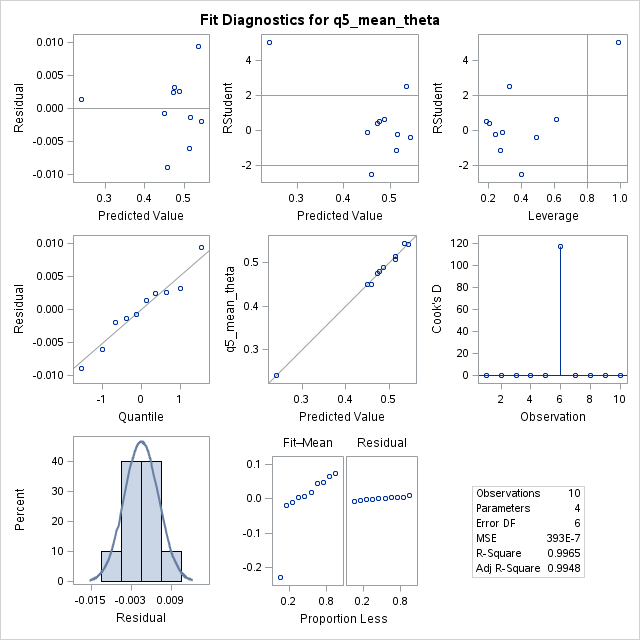
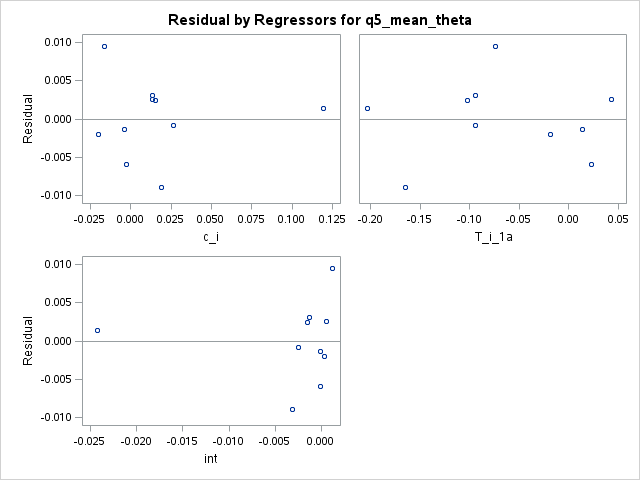

In [9]:
Data cis_int;
set cegs.cis_est_v13  (obs=10);
int= c_i*t_i_1a;
run;

proc sort data=cis_int;
by fusion_id mating_status;
run;

*full model;

proc reg data=cis_int ;
by fusion_id  mating_status;
model q5_mean_theta=c_i t_i_1a int;
ods output ParameterEstimates=parms_full fitstatistics=fit_full;
run;

In [10]:
proc print data=CEGS.r2_ct_models (obs=10); run;

Obs,fusion_id,mating_status,R2_full,R2_noint,R2_cis,R2_diff_int,R2_diff_trans
1,F10005_SI,M,0.9841,0.9632,0.9637,0.0209,-0.0005
2,F10005_SI,V,0.9636,0.8875,0.8487,0.0761,0.0388
3,F10060_SI,M,0.8104,0.7341,0.6474,0.0763,0.0867
4,F10060_SI,V,0.8600,0.8272,0.7507,0.0328,0.0765
5,F10136_SI,M,0.9046,0.9046,0.8673,0.0000,0.0373
6,F10136_SI,V,0.9369,0.9313,0.9166,0.0056,0.0147
7,F10268_SI,M,0.9757,0.9726,0.9727,0.0031,-0.0001
8,F10268_SI,V,0.9740,0.9549,0.9538,0.0191,0.0011
9,F10317_SI,M,0.8816,0.8812,0.0884,0.0004,0.7928
10,F10317_SI,V,0.9078,0.8579,0.1466,0.0499,0.7113



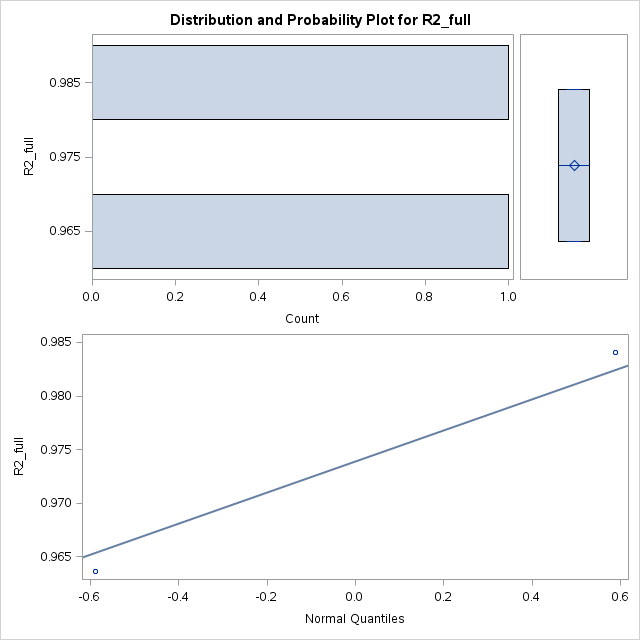
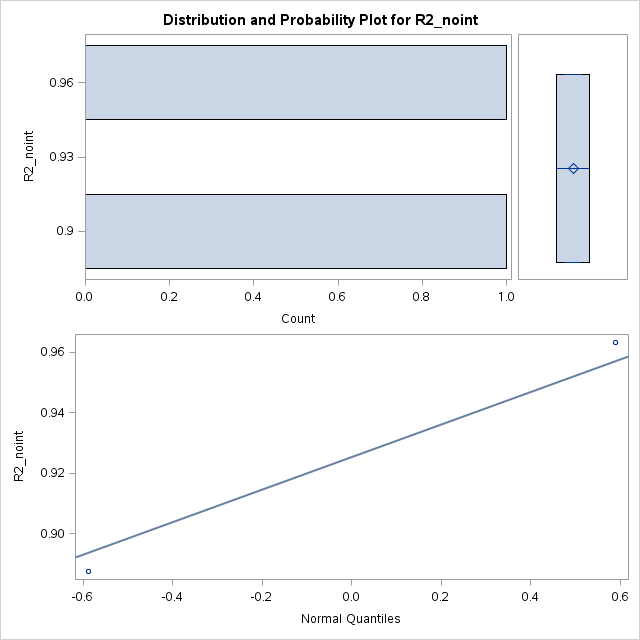
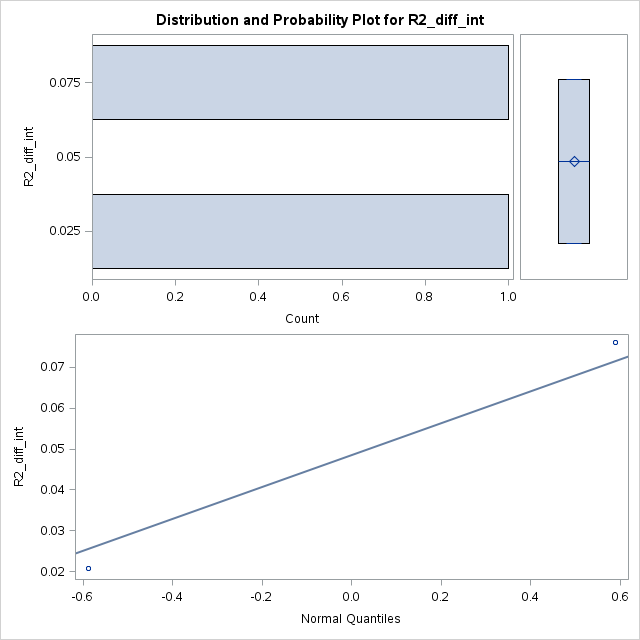
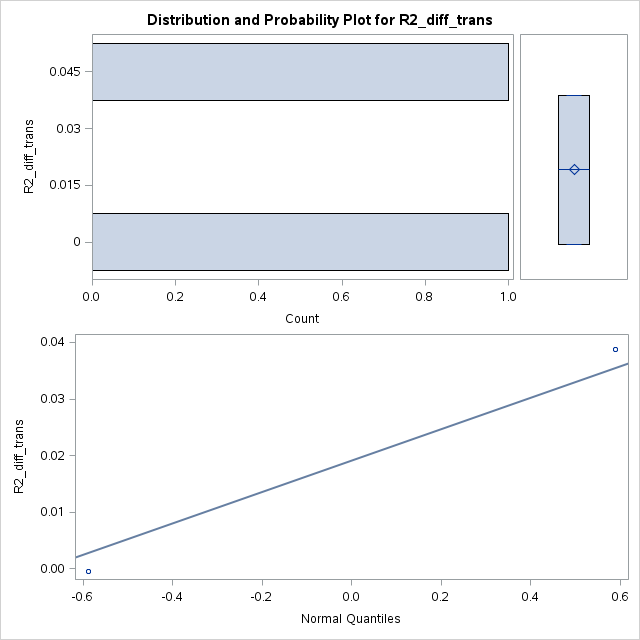
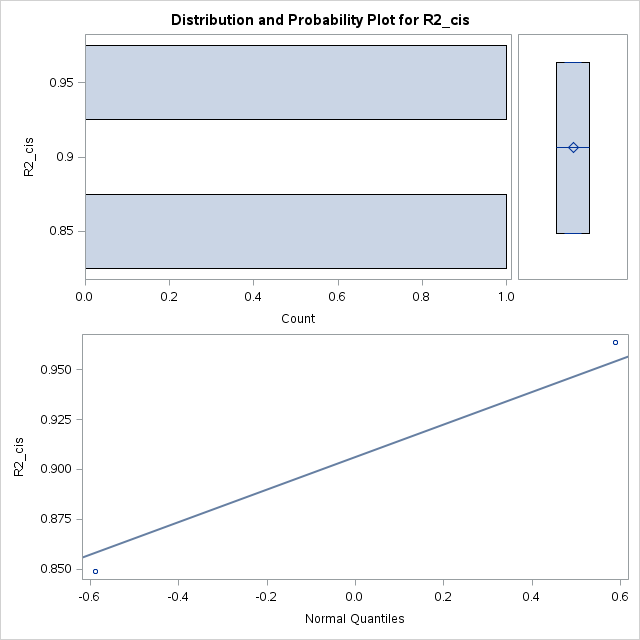

In [11]:
proc univariate data =CEGS.r2_ct_models(obs=2) normal plot  ;
var R2_full R2_noint R2_diff_int R2_diff_trans r2_cis;
run;

## Create data set

Now that I have selected a model, I need to make a dataset with significance flags. While Lauren made a dataset with for comparing model fit, I need to make my own significance flags for the coefficients using the `probt` values. I am going to go ahead and merge mated and virgin side-by-side.

WORK.merge_sig

In [12]:
*proc print data=CEGS.ai_reg_parms_full (obs=10); run;

### Mated Param Flags

In [13]:
data sig_cis;
    set CEGS.ai_reg_parms_full;
    where Variable eq 'c_i' and mating_status eq 'M';
    if probt le 0.05 then flag_sig_cis_m = 1;
    else flag_sig_cis_m = 0;
    keep fusion_id flag_sig_cis_m;
    run;

data sig_trans;
    set CEGS.ai_reg_parms_full;
    where Variable eq 'T_i_1a' and mating_status eq 'M';
    if probt le 0.05 then flag_sig_trans_m = 1;
    else flag_sig_trans_m = 0;
    keep fusion_id flag_sig_trans_m;
    run;
   
data sig_int;
    set CEGS.ai_reg_parms_full;
    where Variable eq 'int' and mating_status eq 'M';
    if probt le 0.05 then flag_sig_int_m = 1;
    else flag_sig_int_m = 0;
    keep fusion_id flag_sig_int_m;
    run;
    
data merge_sig_m;
    merge sig_cis sig_trans sig_int;
    by fusion_id;
    run;
    

### Virgin Param Flags

In [14]:
data sig_cis;
    set CEGS.ai_reg_parms_full;
    where Variable eq 'c_i' and mating_status eq 'V';
    if probt le 0.05 then flag_sig_cis_v = 1;
    else flag_sig_cis_v = 0;
    keep fusion_id flag_sig_cis_v;
    run;

data sig_trans;
    set CEGS.ai_reg_parms_full;
    where Variable eq 'T_i_1a' and mating_status eq 'V';
    if probt le 0.05 then flag_sig_trans_v = 1;
    else flag_sig_trans_v = 0;
    keep fusion_id flag_sig_trans_v;
    run;
   
data sig_int;
    set CEGS.ai_reg_parms_full;
    where Variable eq 'int' and mating_status eq 'V';
    if probt le 0.05 then flag_sig_int_v = 1;
    else flag_sig_int_v = 0;
    keep fusion_id flag_sig_int_v;
    run;
    
data merge_sig_v;
    merge sig_cis sig_trans sig_int;
    by fusion_id;
    run;

### Merge Mated and Virgin Param Flags

In [15]:
data merge_sig;
    merge merge_sig_m merge_sig_v;
    by fusion_id;
    run;
    
proc sort data=merge_sig; by fusion_id; run;

In [16]:
proc print data=merge_sig (obs=10); run;

Obs,fusion_id,flag_sig_cis_m,flag_sig_trans_m,flag_sig_int_m,flag_sig_cis_v,flag_sig_trans_v,flag_sig_int_v
1,F10005_SI,1,0,1,1,1,1
2,F10060_SI,1,1,1,1,1,1
3,F10136_SI,1,1,0,1,0,0
4,F10268_SI,1,0,1,1,0,1
5,F10317_SI,1,1,0,1,1,1
6,F10466_SI,1,1,0,1,1,0
7,F10806_SI,1,1,1,1,1,1
8,F1101_SI,1,1,1,1,0,1
9,F11767_SI,1,1,1,1,0,1
10,F11773_SI,1,0,1,1,0,1


### Freqs of Param Flags to check counts

#### Mated Freqs of cis, trans, int significance

In [17]:
proc freq data=merge_sig;
tables flag_sig_cis_m;
run;

proc freq data=merge_sig;
tables flag_sig_trans_m;
run;

proc freq data=merge_sig;
tables flag_sig_int_m;
run;

flag_sig_cis_m,Frequency,Percent,CumulativeFrequency,CumulativePercent
0,41,4.66,41,4.66
1,839,95.34,880,100.00
flag_sig_trans_m,Frequency,Percent,CumulativeFrequency,CumulativePercent
0,385,43.75,385,43.75
1,495,56.25,880,100.00
flag_sig_int_m,Frequency,Percent,CumulativeFrequency,CumulativePercent
0,168,19.09,168,19.09
1,712,80.91,880,100.00


#### Virgin Freqs of cis, trans, int significance

In [18]:
proc freq data=merge_sig;
tables flag_sig_cis_v;
run;

proc freq data=merge_sig;
tables flag_sig_trans_v;
run;

proc freq data=merge_sig;
tables flag_sig_int_v;
run;

flag_sig_cis_v,Frequency,Percent,CumulativeFrequency,CumulativePercent
0,40,4.55,40,4.55
1,840,95.45,880,100.00
flag_sig_trans_v,Frequency,Percent,CumulativeFrequency,CumulativePercent
0,356,40.45,356,40.45
1,524,59.55,880,100.00
flag_sig_int_v,Frequency,Percent,CumulativeFrequency,CumulativePercent
0,164,18.64,164,18.64
1,716,81.36,880,100.00


### Calculate Percentages of Genotypes with Flags

I need to summarize across the population some how. The easiest way is just to calculate the percentage of lines with a significant (P\<0.05) for cis, trans, and interaction terms.

WORK.pct_ai

#### Mated Percent AI

In [19]:
/* Mated */
data mated;
    set CEGS.clean_ase_sbs;
    keep line fusion_id flag_ai_combined_m;
    run;

proc means data=mated noprint;
    by fusion_id;
    output out=sum sum(flag_ai_combined_m)=sum_ai;
    run;

data m_freq_ai;
    set sum;
    if _FREQ_ gt 0 then m_pct_ai = sum_ai / _FREQ_ * 100;
    else m_pct_ai = 0;
    keep fusion_id m_pct_ai;
    run;

#### Virgin Percent AI

In [20]:
/* Virgin */
data virgin;
    set CEGS.clean_ase_sbs;
    keep line fusion_id flag_ai_combined_v;
    run;

proc means data=virgin noprint;
    by fusion_id;
    output out=sum sum(flag_ai_combined_v)=sum_ai;
    run;

data v_freq_ai;
    set sum;
    if _FREQ_ gt 0 then v_pct_ai = sum_ai / _FREQ_ * 100;
    else v_pct_ai = 0;
    keep fusion_id v_pct_ai;
    run;

#### Merge Mated and Virgin Percent AI

In [21]:
/* Merge */
data pct_ai;
    merge m_freq_ai v_freq_ai;
    by fusion_id;
    run;

proc print data=pct_ai (obs=10); run;

Obs,fusion_id,m_pct_ai,v_pct_ai
1,F10001_SI,0.0000,20.0000
2,F10005_SI,16.6667,16.6667
3,F10009_SI,5.5556,5.5556
4,F10059_SI,7.1429,7.1429
5,F10060_SI,31.0345,31.0345
6,F10072_SI,25.0000,25.0000
7,F10136_SI,29.1667,16.6667
8,F10137_SI,18.1818,22.7273
9,F10147_SI,0.0000,0.0000
10,F10253_SI,21.4286,21.4286


## Merge pct_ai and merge_sig

Merge together my estimate of ai and my flags for different mdoel parameters.

In [22]:
data pct_ai_model;
    merge pct_ai merge_sig;
    by fusion_id;
    if m_pct_ai eq '.' then m_pct_ai = 0;
    if v_pct_ai eq '.' then v_pct_ai = 0;
    
    if flag_sig_cis_m eq '.' then flag_sig_cis_m = 0;
    if flag_sig_trans_m eq '.' then flag_sig_trans_m = 0;
    if flag_sig_int_m eq '.' then flag_sig_int_m = 0;
    
    if flag_sig_cis_v eq '.' then flag_sig_cis_v = 0;
    if flag_sig_trans_v eq '.' then flag_sig_trans_v = 0;
    if flag_sig_int_v eq '.' then flag_sig_int_v = 0;
    run;

In [23]:
proc print data=pct_ai_model(obs=10); run;

Obs,fusion_id,m_pct_ai,v_pct_ai,flag_sig_cis_m,flag_sig_trans_m,flag_sig_int_m,flag_sig_cis_v,flag_sig_trans_v,flag_sig_int_v
1,F10001_SI,0.0000,20.0000,0,0,0,0,0,0
2,F10005_SI,16.6667,16.6667,1,0,1,1,1,1
3,F10009_SI,5.5556,5.5556,0,0,0,0,0,0
4,F10059_SI,7.1429,7.1429,0,0,0,0,0,0
5,F10060_SI,31.0345,31.0345,1,1,1,1,1,1
6,F10072_SI,25.0000,25.0000,0,0,0,0,0,0
7,F10136_SI,29.1667,16.6667,1,1,0,1,0,0
8,F10137_SI,18.1818,22.7273,0,0,0,0,0,0
9,F10147_SI,0.0000,0.0000,0,0,0,0,0,0
10,F10253_SI,21.4286,21.4286,0,0,0,0,0,0


## Summarize to Gene

I order to do any kind of enrichment tests I need to summarize to the gene level. For simplicity I am ignoring the 428 (of 5391) fusions in my dataset that are multi-gene fusions. I am taking the mean across fusions.

WORK.means

In [24]:
data genes;
    set DMEL.FB551_SI_FUSIONS_UNIQUE_FLAGGED;
    keep fusion_id FBgn_cat symbol_cat genes_per_fusion;
    run;
    
proc sort data=genes;
    by fusion_id;
    run;    

proc print data=genes(obs=10);run;

Obs,fusion_id,Genes_per_fusion,symbol_cat,FBgn_cat
1,F10001_SI,2,Catsup|Ttc19,FBgn0002022|FBgn0032744
2,F10005_SI,1,Acn,FBgn0263198
3,F10009_SI,1,Acn,FBgn0263198
4,F10012_SI,2,CG10470|l(2)37Bb,FBgn0002021|FBgn0032746
5,F10014_SI,1,Rpn3,FBgn0261396
6,F10018_SI,1,CG10492,FBgn0032748
7,F10019_SI,1,Phlpp,FBgn0032749
8,F10032_SI,2,CG10702|CG17343,FBgn0032751|FBgn0032752
9,F10049_SI,2,CG17344|CG43731,FBgn0032755|FBgn0263982
10,F10050_SI,2,CG17344|CG43731,FBgn0032755|FBgn0263982


In [25]:
data mg;
    merge pct_ai_model(in=in1) genes(in=in2);
    by fusion_id;
    if in1;
    run;

In [26]:
proc print data=mg(obs=10); run;

Obs,fusion_id,m_pct_ai,v_pct_ai,flag_sig_cis_m,flag_sig_trans_m,flag_sig_int_m,flag_sig_cis_v,flag_sig_trans_v,flag_sig_int_v,Genes_per_fusion,symbol_cat,FBgn_cat
1,F10001_SI,0.0000,20.0000,0,0,0,0,0,0,2,Catsup|Ttc19,FBgn0002022|FBgn0032744
2,F10005_SI,16.6667,16.6667,1,0,1,1,1,1,1,Acn,FBgn0263198
3,F10009_SI,5.5556,5.5556,0,0,0,0,0,0,1,Acn,FBgn0263198
4,F10059_SI,7.1429,7.1429,0,0,0,0,0,0,2,CG10561|Ddc,FBgn0000422|FBgn0002036
5,F10060_SI,31.0345,31.0345,1,1,1,1,1,1,1,Ddc,FBgn0000422
6,F10072_SI,25.0000,25.0000,0,0,0,0,0,0,1,Aats-asn,FBgn0086443
7,F10136_SI,29.1667,16.6667,1,1,0,1,0,0,1,fon,FBgn0032773
8,F10137_SI,18.1818,22.7273,0,0,0,0,0,0,1,fon,FBgn0032773
9,F10147_SI,0.0000,0.0000,0,0,0,0,0,0,1,CG17549,FBgn0032774
10,F10253_SI,21.4286,21.4286,0,0,0,0,0,0,1,CG10186,FBgn0032797


In [27]:
data noMulitGene;
    set mg;
    where genes_per_fusion eq 1;
    run;

In [28]:
proc print data=noMulitGene (obs=10); run;

Obs,fusion_id,m_pct_ai,v_pct_ai,flag_sig_cis_m,flag_sig_trans_m,flag_sig_int_m,flag_sig_cis_v,flag_sig_trans_v,flag_sig_int_v,Genes_per_fusion,symbol_cat,FBgn_cat
1,F10005_SI,16.6667,16.6667,1,0,1,1,1,1,1,Acn,FBgn0263198
2,F10009_SI,5.5556,5.5556,0,0,0,0,0,0,1,Acn,FBgn0263198
3,F10060_SI,31.0345,31.0345,1,1,1,1,1,1,1,Ddc,FBgn0000422
4,F10072_SI,25.0000,25.0000,0,0,0,0,0,0,1,Aats-asn,FBgn0086443
5,F10136_SI,29.1667,16.6667,1,1,0,1,0,0,1,fon,FBgn0032773
6,F10137_SI,18.1818,22.7273,0,0,0,0,0,0,1,fon,FBgn0032773
7,F10147_SI,0.0000,0.0000,0,0,0,0,0,0,1,CG17549,FBgn0032774
8,F10253_SI,21.4286,21.4286,0,0,0,0,0,0,1,CG10186,FBgn0032797
9,F10259_SI,10.0000,0.0000,0,0,0,0,0,0,1,CG10186,FBgn0032797
10,F10268_SI,9.5238,21.4286,1,0,1,1,0,1,1,CG10186,FBgn0032797


In [29]:
proc sort data=noMulitGene;
    by FBgn_cat;
    run;

proc means data=noMulitGene noprint;
    by  FBgn_cat;
    output out=means 
    mean(m_pct_ai)=m_pct_ai_bar 
    mean(v_pct_ai)=v_pct_ai_bar

    sum(flag_sig_cis_m)=flag_sig_cis_m_sum
    sum(flag_sig_trans_m)=flag_sig_trans_m_sum
    sum(flag_sig_int_m)=flag_sig_int_m_sum

    sum(flag_sig_cis_v)=flag_sig_cis_v_sum
    sum(flag_sig_trans_v)=flag_sig_trans_v_sum
    sum(flag_sig_int_v)=flag_sig_int_v_sum
    ;

    run;
    
data means;
    set means;
    if flag_sig_cis_m_sum > 0 then flag_sig_cis_m_sum = 1;
    if flag_sig_trans_m_sum > 0 then flag_sig_trans_m_sum = 1;
    if flag_sig_int_m_sum > 0 then flag_sig_int_m_sum = 1;
    if flag_sig_cis_v_sum > 0 then flag_sig_cis_v_sum = 1;
    if flag_sig_trans_v_sum > 0 then flag_sig_trans_v_sum = 1;
    if flag_sig_int_v_sum > 0 then flag_sig_int_v_sum = 1;
    run;

In [30]:
proc print data=means (obs=10); run;

Obs,FBgn_cat,_TYPE_,_FREQ_,m_pct_ai_bar,v_pct_ai_bar,flag_sig_cis_m_sum,flag_sig_trans_m_sum,flag_sig_int_m_sum,flag_sig_cis_v_sum,flag_sig_trans_v_sum,flag_sig_int_v_sum
1,FBgn0000024,0,2,43.6508,49.2063,0,0,0,0,0,0
2,FBgn0000038,0,4,15.9926,14.8581,1,1,1,1,1,1
3,FBgn0000042,0,1,17.8571,25.0000,1,1,1,1,1,1
4,FBgn0000044,0,1,12.5000,50.0000,0,0,0,0,0,0
5,FBgn0000046,0,1,10.0000,15.0000,0,0,0,0,0,0
6,FBgn0000052,0,1,33.3333,22.2222,0,0,0,0,0,0
7,FBgn0000053,0,5,11.5098,12.6863,0,0,0,0,0,0
8,FBgn0000064,0,2,51.6327,50.2381,1,1,1,1,1,1
9,FBgn0000108,0,3,13.9971,16.5570,1,1,1,1,0,1
10,FBgn0000114,0,1,0.0000,0.0000,0,0,0,0,0,0


In [31]:
proc print data=noMulitGene(where=(FBgn_cat eq 'FBgn0000064')); run;

Obs,fusion_id,m_pct_ai,v_pct_ai,flag_sig_cis_m,flag_sig_trans_m,flag_sig_int_m,flag_sig_cis_v,flag_sig_trans_v,flag_sig_int_v,Genes_per_fusion,symbol_cat,FBgn_cat
16,F60648_SI,40.0000,43.3333,1,0,1,1,0,1,1,Ald,FBgn0000064
17,F60652_SI,63.2653,57.1429,1,1,1,1,1,1,1,Ald,FBgn0000064


## Import Transcription Factor Gene List

Clone github repository that I created with some transcription factor gene lists.

WORK.TF2

In [32]:
%%shell
cd /home/jfear/devel
git clone https://github.com/Oliver-Lab/genelists.git

fatal: destination path 'genelists' already exists and is not an empty directory.
/home/jfear/devel
fatal: destination path 'genelists' already exists and is not an empty directory.


Import gene list

In [33]:
proc import datafile='!HOME/devel/genelists/transcription_factors/Rhee_2014/genesList' out=tf dbms=csv replace;
getnames=no;
run;

In [34]:
proc print data=tf (obs=10); run;

Obs,VAR1
1,FBgn0000014
2,FBgn0000015
3,FBgn0000018
4,FBgn0000022
5,FBgn0000028
6,FBgn0000054
7,FBgn0000061
8,FBgn0000097
9,FBgn0000099
10,FBgn0000137


### Make sure FBgns match current annotation

I am not sure what FlyBase version these FBgn number are. I want to make sure that they match with the current annotation, so I will try merging to the full gene list.

In [35]:
proc sort data=tf;
    by VAR1;
    run;

In [36]:
data FBgns;
    set DMEL.FBGN2COORD;
    keep primary_fbgn;
    run;

proc sort data=FBgns nodups;
    by primary_FBgn;
    run;

In [37]:
data mgFbgn_Test;
    merge FBgns (in=in1) tf (in=in2 rename=(VAR1=primary_fbgn));
    by primary_fbgn;
    if in2 and not in1;
run;
proc print data=mgFbgn_Test; run;

Obs,primary_fbgn
1,FBgn0014467
2,FBgn0083919


There are 2 FBgns that are not in my annotation.

[FBgn0014467](http://flybase.org/reports/FBgn0265784.html) comes up as FBgn0265784 (Dmel\CrebB)

[FBgn0083919](http://flybase.org/reports/FBgn0265991.html) comes up as FBgn0265991 (Dmel\Zasp52)

Check if these are in my big FBgn List.

In [38]:
proc print data=FBgns (where=(primary_fbgn eq 'FBgn0265784' or primary_fbgn eq 'FBgn0265991')); run;

Obs,primary_fbgn
16168,FBgn0265784
16366,FBgn0265991


Yes they are present, so I can just rename FBgn0014467 and FBgn0083919.

In [39]:
data tf2;
    rename VAR1 = FBgn_cat;
    set tf;
    if VAR1 eq 'FBgn0014467' then VAR1 = 'FBgn0265784';     
    if VAR1 eq 'FBgn0083919' then VAR1 = 'FBgn0265991';
    run;

In [40]:
proc sort data=tf2;
by FBgn_cat;
run;

data mgFbgn_Test;
    merge FBgns (in=in1) tf2 (in=in2 rename=(FBgn_cat=primary_fbgn));
    by primary_fbgn;
    if in2 and not in1;
run;

## Merge TFs to Summarized dataset

CEGS.mgTFsig

In [41]:
data CEGS.mgTFsig;
    merge TF2 (in=in1) means (in=in2);
    by FBgn_cat;
    if in1 then flag_tf = 1;
    if in2 and not in1 then flag_tf = 0;
    if in2;
    run;

In [42]:
proc print data=CEGs.mgTFsig(obs=10); run;

Obs,FBgn_cat,_TYPE_,_FREQ_,m_pct_ai_bar,v_pct_ai_bar,flag_sig_cis_m_sum,flag_sig_trans_m_sum,flag_sig_int_m_sum,flag_sig_cis_v_sum,flag_sig_trans_v_sum,flag_sig_int_v_sum,flag_tf
1,FBgn0000024,0,2,43.6508,49.2063,0,0,0,0,0,0,0
2,FBgn0000038,0,4,15.9926,14.8581,1,1,1,1,1,1,0
3,FBgn0000042,0,1,17.8571,25.0000,1,1,1,1,1,1,0
4,FBgn0000044,0,1,12.5000,50.0000,0,0,0,0,0,0,0
5,FBgn0000046,0,1,10.0000,15.0000,0,0,0,0,0,0,0
6,FBgn0000052,0,1,33.3333,22.2222,0,0,0,0,0,0,0
7,FBgn0000053,0,5,11.5098,12.6863,0,0,0,0,0,0,0
8,FBgn0000064,0,2,51.6327,50.2381,1,1,1,1,1,1,0
9,FBgn0000108,0,3,13.9971,16.5570,1,1,1,1,0,1,0
10,FBgn0000114,0,1,0.0000,0.0000,0,0,0,0,0,0,0


## Enrichments

In [43]:
proc freq data=CEGs.mgTFsig;
    table flag_tf*flag_sig_cis_m_sum / chisq;
    run;

In [44]:
proc freq data=CEGs.mgTFsig;
    table flag_tf*flag_sig_cis_v_sum / chisq;
    run;

In [45]:
proc freq data=CEGs.mgTFsig;
    table flag_tf*flag_sig_trans_m_sum / chisq;
    run;

In [46]:
proc freq data=CEGs.mgTFsig;
    table flag_tf*flag_sig_trans_v_sum / chisq;
    run;

In [47]:
proc freq data=CEGs.mgTFsig;
    table flag_tf*flag_sig_int_m_sum / chisq;
    run;

In [48]:
proc freq data=CEGs.mgTFsig;
    table flag_tf*flag_sig_int_v_sum / chisq;
    run;

### Mated AI in > 50%

In [49]:
data mm;
    set CEGS.mgTFsig;
    if m_pct_ai_bar ge 50;
    run;

proc freq data=mm;
    table flag_tf*flag_sig_cis_m_sum / chisq;
    run;
    
proc freq data=mm;
    table flag_tf*flag_sig_trans_m_sum / chisq;
    run;
    
proc freq data=mm;
    table flag_tf*flag_sig_int_m_sum / chisq;
    run;

In [50]:
data vv;
    set CEGS.mgTFsig;
    if v_pct_ai_bar ge 50;
    run;

proc freq data=vv;
    table flag_tf*flag_sig_cis_v_sum / chisq;
    run;
    
proc freq data=vv;
    table flag_tf*flag_sig_trans_v_sum / chisq;
    run;
    
proc freq data=vv;
    table flag_tf*flag_sig_int_v_sum / chisq;
    run;